In [26]:
#Import all libraries (as listed in requirements.txt):
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
from scipy import misc
import skimage.measure

import pandas as pd #used for data importing and manipulation
import numpy as np
from PIL import Image #good for generating new image data
from sklearn import cluster
from sklearn import preprocessing
import skimage
import glob
import os


In [27]:
def img_info(ndarray, gray=0):
    '''displays image and shape; gray is a flag used by matplotlib'''
    if gray:
        plt.imshow(ndarray,cmap='gray')
    else:
        plt.tight_layout()
        plt.title('Image shape: '+str(ndarray.shape))
        plt.imshow(ndarray);
        plt.savefig(str(ndarray.shape)+'.png')
    #print('Image shape:', ndarray.shape)

def image_data_from_number(imageNumber, imagesPath):
    filename = imagesPath+str(imageNumber)+'.png'
    image = skimage.io.imread(filename, as_gray=False)
    return image#raw image data

def csv_to_df(csvPath):
    df = pd.read_csv(csvPath)
    return df

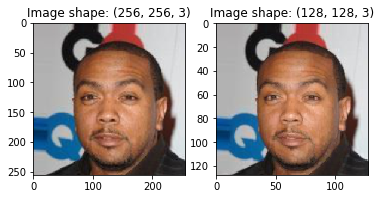

In [47]:
def plt_images(ndarray1, ndarray2):
    #plt.tight_layout()
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.title('Image shape: '+str(ndarray1.shape))
    plt.imshow(ndarray1)
    f.add_subplot(1,2, 2)
    plt.title('Image shape: '+str(ndarray2.shape))
    plt.imshow(ndarray2)
    plt.savefig('downsample_comparison.png')
    plt.show(block=True)
    
plt_images(img, downsample)


In [28]:
currentDirectory = os.path.dirname("__file__")
csvPath = os.path.join(currentDirectory, 'attribute_list.csv')
imagesPath =  os.path.join(currentDirectory, '../images/')

In [29]:
img = image_data_from_number(250, imagesPath)

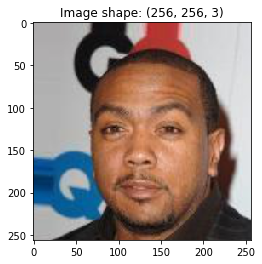

In [30]:
img_info(img)

In [31]:
grayscale = skimage.color.rgb2gray(img)

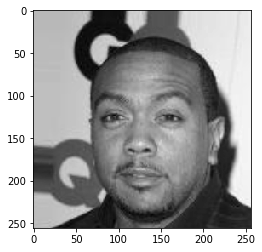

In [32]:
img_info(grayscale, gray=1)

In [33]:
downsample = skimage.measure.block_reduce(img, (2,2,1), np.max)

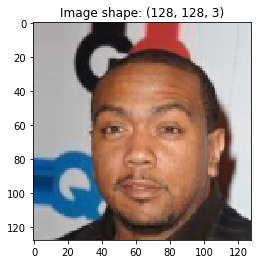

In [34]:
img_info(downsample, gray=0)

In [10]:
stats = [np.min, np.max, np.mean, np.std]
for stat in stats:
    print( str(stat), stat(grayscale) )


<function amin at 0x7fa91c2998c8> 0.011764705882352941
<function amax at 0x7fa91c299840> 0.9308482352941176
<function mean at 0x7fa91c299d08> 0.4874515130316043
<function std at 0x7fa91c299d90> 0.24343313617436907


In [11]:
standardize = (downsample - downsample.mean()) / np.sqrt(downsample.var() + 1e-5)


In [12]:
for stat in stats:
    print( str(stat), stat(standardize) )

<function amin at 0x7fa91c2998c8> -1.9948612413907574
<function amax at 0x7fa91c299840> 1.7331909521767574
<function mean at 0x7fa91c299d08> 9.71445146547012e-17
<function std at 0x7fa91c299d90> 0.9999069440427982


Image shape: (64, 64)


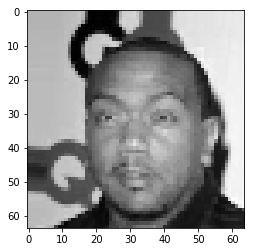

In [13]:
img_info(standardize, gray=1)

In [17]:
def create_image_dataset(csvPath, imagesPath):
    df = csv_to_df(csvPath)
    flattenedImageShape = (df.shape[0], 64*64)
    dataset = np.ndarray(shape=flattenedImageShape, dtype=np.float32)
    
    for index, row in df.iterrows():
        image = image_data_from_number(row['file_name'], imagesPath)
        grayscale = skimage.color.rgb2gray(image)
        downsample = skimage.measure.block_reduce(grayscale, (2,2), np.max)
        standardize = (downsample - downsample.mean()) / np.sqrt(downsample.var() + 1e-5)
        
        dataset[index] = standardize.flatten()
    
    return dataset

In [18]:
dataset = create_image_dataset(csvPath, imagesPath)
np.save('Images-gray-standardized', dataset)

ValueError: Wrong number of items passed 4096, placement implies 1

In [42]:
df = csv_to_df(csvPath)
df = df.drop('file_name', 1)

In [20]:
mms = preprocessing.MinMaxScaler()
mms.fit(dataset)
data_transformed = mms.transform(dataset)

In [76]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = cluster.KMeans(n_clusters=k)
    km = km.fit(oneHotDf)
    Sum_of_squared_distances.append(km.inertia_)

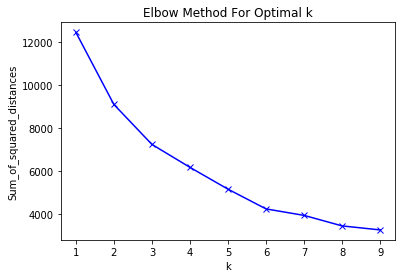

In [77]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [78]:
def cluster_images(dataset, path):
    #we can tell that k=4 is around the optimal # of clusters
    #from using the elbow method on the graph above
    
    #dataset should be array-like or sparse matrix, shape=(n_samples, n_features)
    k_means = cluster.KMeans(n_clusters=3)
    k_means.fit_predict(dataset)
    clusters_means = k_means.cluster_centers_.squeeze()
    image_clusters = k_means.labels_

    print('# of Observations:', dataset.shape)
    print('Clusters Means:', clusters_means)
    print('labels:', image_clusters)
    np.savetxt('labelsarray.csv', image_clusters)
    return image_clusters

image_clusters = cluster_images(oneHotDf, currentDirectory)
df = csv_to_df(csvPath)
df['cluster'] = image_clusters
df.to_csv('attribute_list_onehot_w_clusters.csv')


# of Observations: (5000, 15)
Clusters Means: [[ 4.30735931e-01  4.83405483e-02  4.54545455e-02  3.31679129e-15
   3.67965368e-02  5.05050505e-02  3.88167388e-01  7.87157287e-01
   2.12842713e-01  4.53823954e-01  5.46176046e-01  1.00000000e+00
  -6.10622664e-15  6.68109668e-01  3.31890332e-01]
 [-1.00197628e-14 -8.43075609e-16  3.34939759e-01  2.63614458e-01
   2.56867470e-01  1.44578313e-01 -3.13638004e-15  5.27710843e-01
   4.72289157e-01  1.29896094e-14  1.00000000e+00  5.71764858e-15
   1.00000000e+00  9.99518072e-01  4.81927711e-04]
 [ 3.25536062e-01  1.36452242e-02  1.53996101e-01  3.60822483e-15
   2.33268356e-01  2.71604938e-01  1.94931774e-03  9.65562053e-01
   3.44379467e-02  4.78882391e-01  5.21117609e-01  5.49560397e-15
   1.00000000e+00 -1.53210777e-14  1.00000000e+00]]
labels: [1 2 0 ... 2 1 0]


In [83]:
#one-hot-enconding:
df = csv_to_df(csvPath)
fileNameDf = df['file_name']
df = df.drop('file_name', 1)

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(categories='auto')
enc.fit(df)
onehotlabels = enc.transform(df).toarray()
print(enc.get_feature_names())
print(onehotlabels.shape)
oneHotCols = ["hair_-1", "hair_0", "hair_1", "hair_2", "hair_3", "hair_4",
              "hair_5", "eyeglasses_-1", "eyeglasses_1", "smiling_-1", "smiling_1", 
              "young_-1", "young_1", "human_-1", "human_1"]


oneHotDf = pd.DataFrame(onehotlabels, columns = oneHotCols)
print(oneHotDf.head())

oneHotDf.to_csv('attribute_list_onehot.csv')

['x0_-1' 'x0_0' 'x0_1' 'x0_2' 'x0_3' 'x0_4' 'x0_5' 'x1_-1' 'x1_1' 'x2_-1'
 'x2_1' 'x3_-1' 'x3_1' 'x4_-1' 'x4_1']
(5000, 15)
   hair_-1  hair_0  hair_1  hair_2  hair_3  hair_4  hair_5  eyeglasses_-1  \
0      0.0     0.0     1.0     0.0     0.0     0.0     0.0            1.0   
1      0.0     0.0     0.0     0.0     0.0     1.0     0.0            1.0   
2      0.0     0.0     0.0     0.0     0.0     0.0     1.0            1.0   
3      1.0     0.0     0.0     0.0     0.0     0.0     0.0            1.0   
4      1.0     0.0     0.0     0.0     0.0     0.0     0.0            1.0   

   eyeglasses_1  smiling_-1  smiling_1  young_-1  young_1  human_-1  human_1  
0           0.0         0.0        1.0       0.0      1.0       1.0      0.0  
1           0.0         0.0        1.0       0.0      1.0       0.0      1.0  
2           0.0         0.0        1.0       1.0      0.0       1.0      0.0  
3           0.0         1.0        0.0       1.0      0.0       1.0      0.0  
4           0.0   

In [84]:
image_clusters = cluster_images(oneHotDf, currentDirectory)
oneHotDf['cluster'] = image_clusters
oneHotDf.to_csv('attribute_list_onehot_w_clusters.csv')


# of Observations: (5000, 15)
Clusters Means: [[-1.04083409e-14  6.51041667e-03  3.01649306e-01  2.37413194e-01
   2.31336806e-01  1.30208333e-01  9.28819444e-02  4.75260417e-01
   5.24739583e-01  1.42663659e-14  1.00000000e+00  9.93923611e-02
   9.00607639e-01  9.99565972e-01  4.34027778e-04]
 [ 3.00539892e-01  1.25974805e-02  1.73365327e-01  3.81639165e-15
   2.33953209e-01  2.77744451e-01  1.79964007e-03  9.64007199e-01
   3.59928014e-02  4.42111578e-01  5.57888422e-01  7.67846431e-02
   9.23215357e-01 -1.58761893e-14  1.00000000e+00]
 [ 5.80174927e-01  5.05344995e-02  1.06899903e-02  2.28983499e-15
   1.94363460e-02  2.42954325e-02  3.14868805e-01  9.42662779e-01
   5.73372206e-02  6.11273081e-01  3.88726919e-01  1.00000000e+00
  -5.88418203e-15  6.77356657e-01  3.22643343e-01]]
labels: [0 1 2 ... 1 0 2]


In [86]:
#testing extracting image features with Keras pretrained models

"""Preprocess images using Keras pre-trained models."""

import argparse
import csv
import os

from keras import applications
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
import numpy as np
import pandas


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


def named_model(name):
    # include_top=False removes the fully connected layer at the end/top of the network
    # This allows us to get the feature vector as opposed to a classification
    if name == 'Xception':
        return applications.xception.Xception(weights='imagenet', include_top=False, pooling='avg')

    if name == 'VGG16':
        return applications.vgg16.VGG16(weights='imagenet', include_top=False, pooling='avg')

    if name == 'VGG19':
        return applications.vgg19.VGG19(weights='imagenet', include_top=False, pooling='avg')

    if name == 'InceptionV3':
        return applications.inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling='avg')

    if name == 'MobileNet':
        return applications.mobilenet.MobileNet(weights='imagenet', include_top=False, pooling='avg')

    return applications.resnet50.ResNet50(weights='imagenet', include_top=False, pooling='avg')


parser = argparse.ArgumentParser(prog='Feature extractor')
parser.add_argument(
    'model',
    default='ResNet50',
    nargs="?",
    type=named_model,
    help='Name of the pre-trained model to use'
)

pargs = parser.parse_args()
currentDirectory = os.path.dirname("__file__")
csvPath = os.path.join(currentDirectory, 'attribute_list.csv')
imagesPath =  os.path.join(currentDirectory, 'dataset/')

def get_feature(imageName):
    try:
        img_path = os.path.join(source_dir, imageName)
        if os.path.isfile(img_path):
            print('is file: {}'.format(img_path))
            try:
                # load image setting the image size to 224 x 224
                img = image.load_img(img_path, target_size=(224, 224))
                # convert image to numpy array
                x = image.img_to_array(img)
                # the image is now in an array of shape (3, 224, 224)
                # but we need to expand it to (1, 2, 224, 224) as Keras is expecting a list of images
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)

                # extract the features
                features = pargs.model.predict(x)[0]
                # convert from Numpy to a list of values
                features_arr = np.char.mod('%f', features)

                return features_arr
            except Exception as ex:
                # skip all exceptions for now
                print(ex)
                pass
    except Exception as ex:
        # skip all exceptions for now
        print(ex)
        pass
    return None


def start():
    try:

        # extract features
        features = get_feature('100.png')
        
        features = filter(None, features)

        # remove empty entries

        print(features)

    except EnvironmentError as e:
        print(e)


if __name__ == '__main__':
start()

Using TensorFlow backend.
usage: Feature extractor [-h] [model]
Feature extractor: error: unrecognized arguments: -f


SystemExit: 2

/home/ilyas/dev/environments/AMLSassignment/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [91]:
id_list = range(1, 51)
image_list = []
for i in range (1, 51):
    image_list.append(str(i)+'.png')
csv_df = pd.DataFrame(
    {'id': id_list,
     'image': image_list})
csv_df.to_csv('image_list.tsv', sep='\t')
    

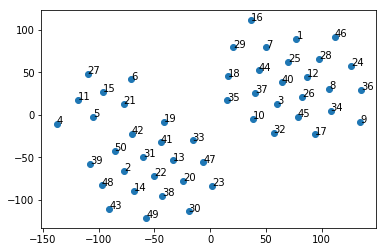

In [98]:
image_list_tsne = pd.read_csv('image_list_features_tsne.tsv', sep='\t')
image_list_tsne['x'].head()
fig, ax = plt.subplots()
x =  image_list_tsne['x']
y = image_list_tsne['y']
ax.scatter(image_list_tsne['x'], image_list_tsne['y'])
for i, txt in enumerate(image_list_tsne.index.values+1):
    ax.annotate(txt, (x[i], y[i]))
plt.show()